In [1]:
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import datetime
import os
from WindPy import w
from scipy.stats import stats
from sklearn import linear_model
%matplotlib inline

In [2]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!
You can use w.menu to help yourself to create commands(WSD,WSS,WST,WSI,WSQ,...)!

COPYRIGHT (C) 2016 WIND HONGHUI INFORMATION & TECHKNOLEWDGE CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [3]:
BY_STOCK_DIR = "D:/Data/avg_cost/by stock"
BY_DATE_DIR = "D:/Data/avg_cost/by date"

# 读入全市场所有股票的历史换手天数、持有成本与收盘价

In [4]:
files = [f for f in os.listdir(BY_STOCK_DIR)]

In [5]:
len(files)

800

In [6]:
dic = {}
for stock in files:
    df = pd.read_excel("%s/%s"%(BY_STOCK_DIR, stock), index_col=0)
    df.index = pd.to_datetime(df.index)
    dic[stock[:-5]] = df
pnl = pd.Panel(dic)

In [7]:
pnl

<class 'pandas.core.panel.Panel'>
Dimensions: 800 (items) x 539 (major_axis) x 3 (minor_axis)
Items axis: 000001.SZ to 603993.SH
Major_axis axis: 2015-01-05 00:00:00.005000 to 2017-03-21 00:00:00.005000
Minor_axis axis: turnover days to close

# 计算每只股票每日浮盈/浮亏与滚动浮盈/浮亏

In [8]:
pnl.ix[:, :, "current return"] = (pnl.minor_xs("close") - pnl.minor_xs("avg cost")) / pnl.minor_xs("avg cost")

In [9]:
t = 7
pnl.ix[:, :, "rolling current return"] = pnl.minor_xs("current return").rolling(window=t).mean()

In [10]:
end_date = pnl["000001.SZ"].dropna().index[-1]

# 计算全市场的浮盈/浮亏与滚动浮盈浮亏

In [11]:
dates = pnl["000001.SZ"].index

In [12]:
market_df = pd.DataFrame(index=dates)

In [13]:
market_df.loc[:, "current return"] = pnl.ix[:, :, "current return"].mean(axis=1)

In [14]:
market_df.loc[:, "rolling current return"] = pnl.ix[:, :, "rolling current return"].mean(axis=1)

In [15]:
market_df = market_df[market_df.index <= end_date]

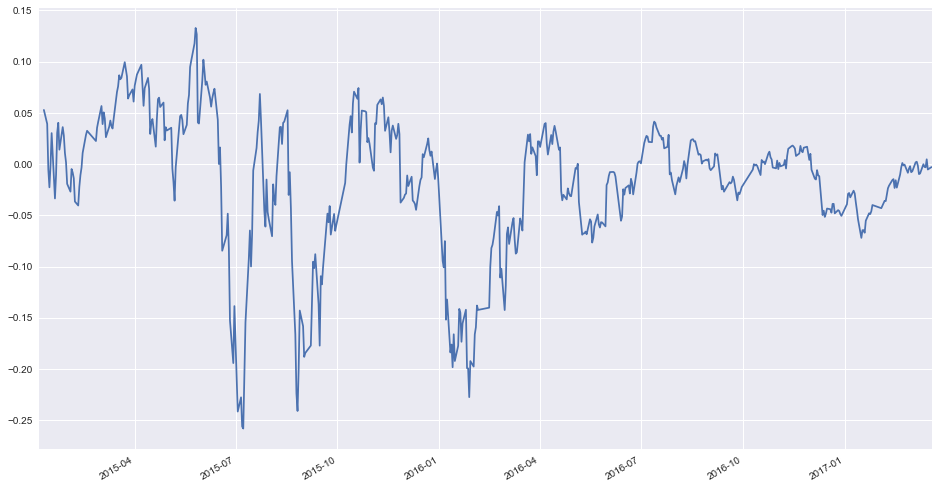

In [16]:
plt.figure(figsize=(16, 9))
market_df["current return"].plot()
# market_df["rolling current return"].plot()

In [17]:
market_df.tail()

,current return,rolling current return
2017-03-15 00:00:00.005,-0.003159,-0.003453
2017-03-16 00:00:00.005,0.004679,-0.003114
2017-03-17 00:00:00.005,-0.005300,-0.003660
2017-03-20 00:00:00.005,-0.003122,-0.002709
2017-03-21 00:00:00.005,-0.002829,-0.001797


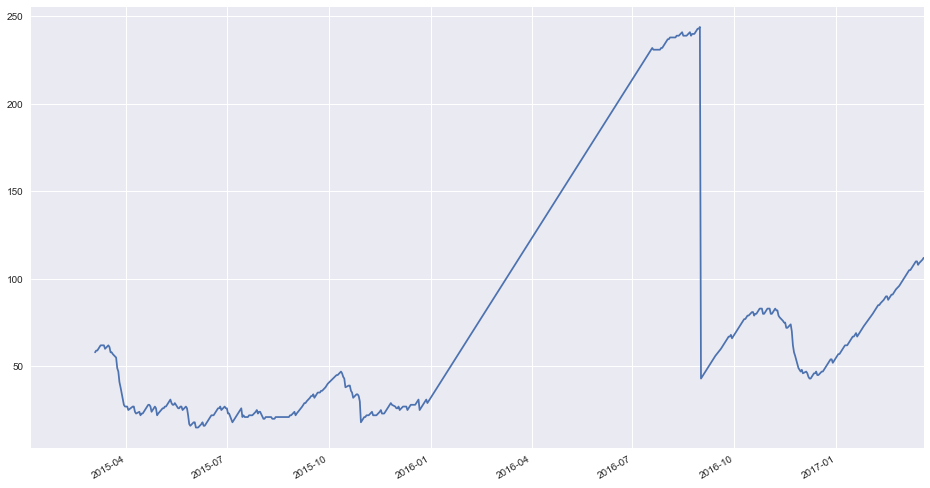

In [18]:
plt.figure(figsize=(16, 9))
pnl["000718.SZ"]["turnover days"].plot()

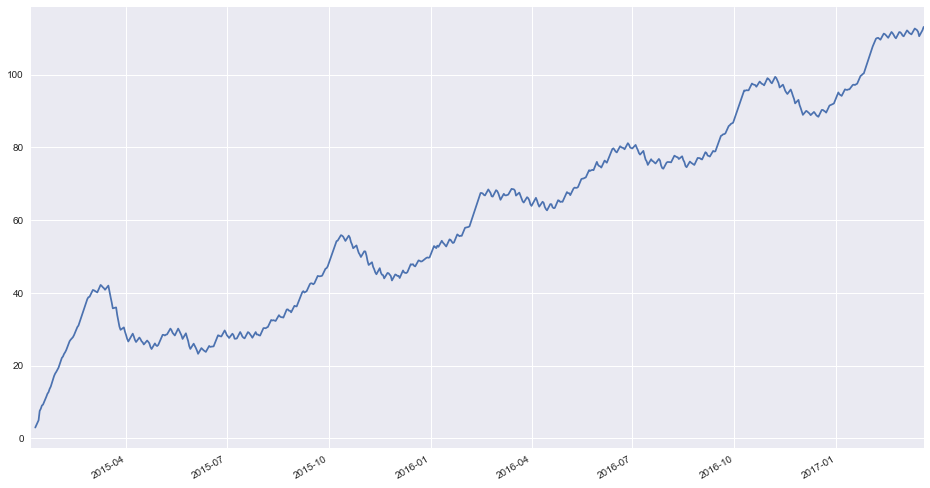

In [19]:
plt.figure(figsize=(16, 9))
pnl.minor_xs("turnover days").mean(axis=1).plot()

# 得到市场的收盘价

In [20]:
code = "000300.SH"
start_date = market_df.index[0].strftime("%Y-%m-%d")
end_date = market_df.index[-1].strftime("%Y-%m-%d")
data = w.wsd(code, "close", beginTime=start_date, endTime=end_date)

In [21]:
def wind2df(raw_data):
    dic = {}
    for data, field in zip(raw_data.Data, raw_data.Fields):
        dic[str(field.lower())] = data
    return pd.DataFrame(dic, index=raw_data.Times)

In [22]:
df = wind2df(data)

In [23]:
market_df["close"] = df["close"]

# 计算浮盈/浮亏的zscore

In [24]:
col_name = "rolling current return"
market_df["z-score"] = (market_df[col_name] - market_df[col_name].mean()) / market_df[col_name].std()
market_df["price z-score"] = (market_df["close"] - market_df["close"].mean()) / market_df["close"].std()

In [25]:
market_df.ix[-1]

current return              -0.002829
rolling current return      -0.001797
close                     3466.346800
z-score                      0.259121
price z-score               -0.187388
Name: 2017-03-21 00:00:00.005000, dtype: float64

In [26]:
market_df.to_excel("market.xlsx")

In [27]:
market_df = pd.read_excel("market.xlsx", index_col=0)

In [28]:
res = []
for k in range(1, 200):
    corr = market_df["z-score"].corr(market_df["price z-score"].pct_change(k).shift(-k))
    res.append(corr)

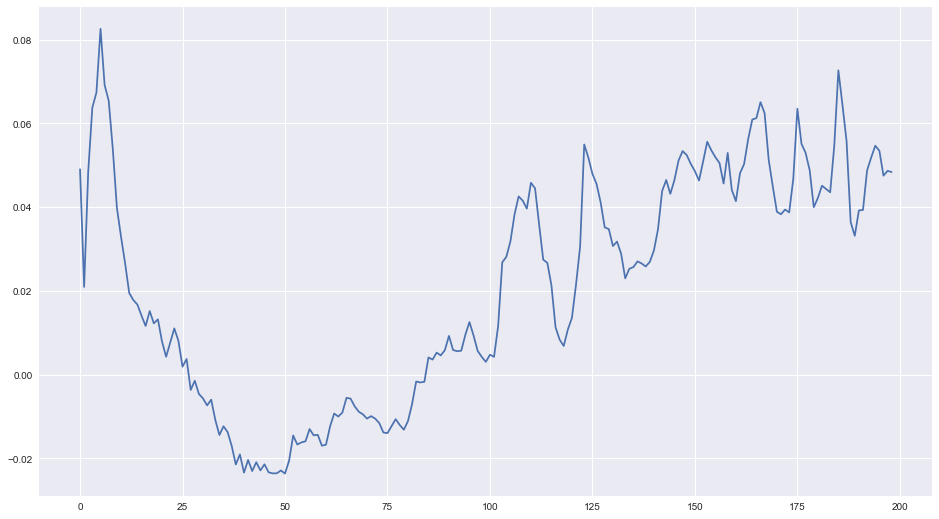

In [29]:
plt.figure(figsize=(16, 9))
plt.plot(-np.array(res))

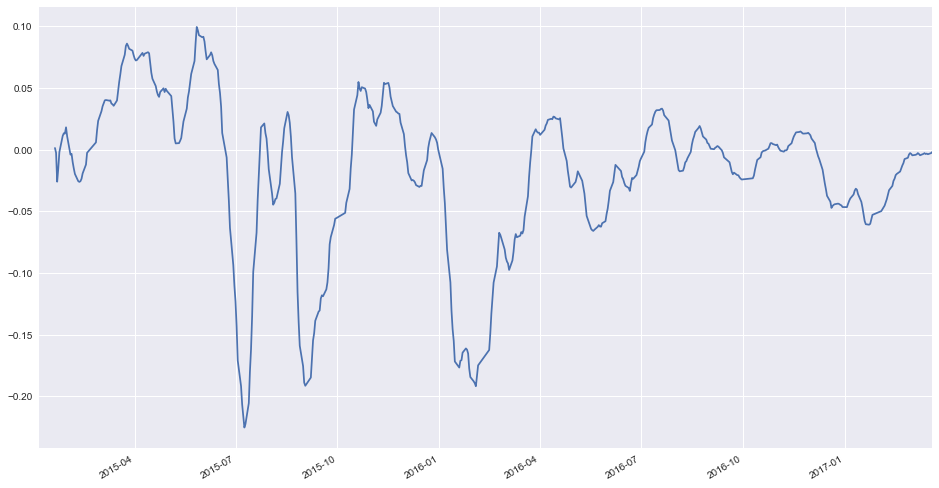

In [30]:
plt.figure(figsize=(16, 9))
market_df["rolling current return"].plot()

C:\Users\jgtzsx01\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\transforms.py:661: RuntimeWarning: invalid value encountered in absolute
  inside = ((abs(dx0 + dx1) + abs(dy0 + dy1)) == 0)


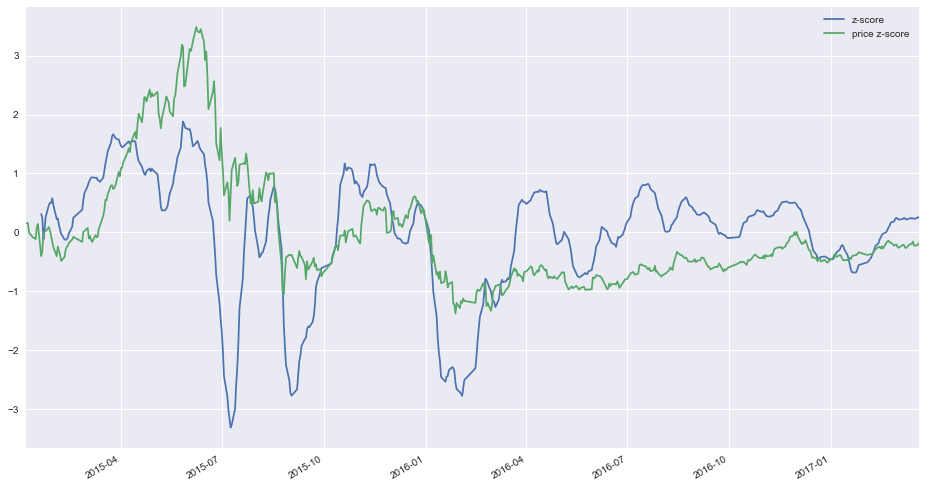

In [31]:
plt.figure(figsize=(16, 9))
market_df["z-score"].plot(legend=True)
market_df["price z-score"].plot(legend=True)

# 某一天市场100%换手天数分布

In [43]:
date = "2015-07-07"
fname = "%s/%s.xlsx"%(BY_DATE_DIR, date)

In [44]:
df = pd.read_excel(fname, index_col=0)
df["current return"] = (df["close"] - df["avg cost"]) / df["avg cost"]
d = df["turnover days"].dropna()

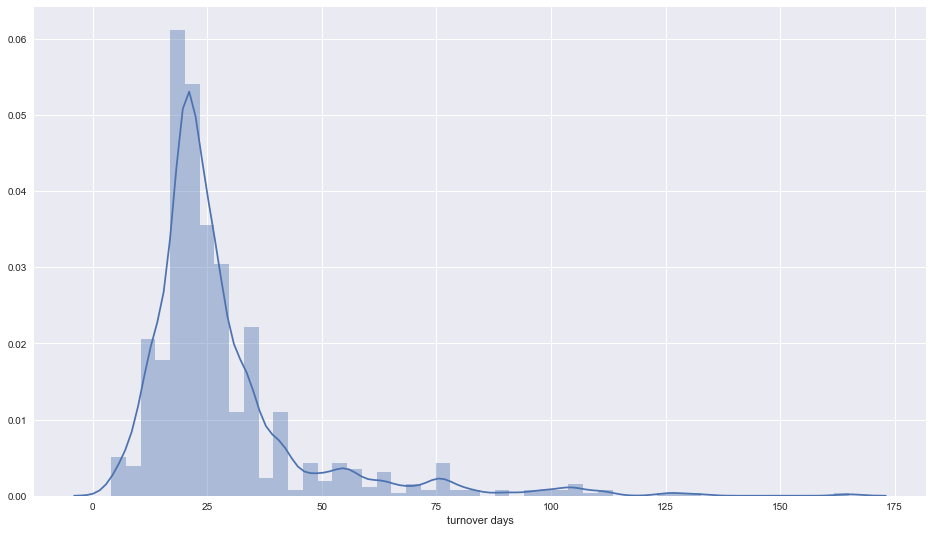

In [45]:
plt.figure(figsize=(16, 9))
sns.distplot(d)

In [46]:
stats.kurtosis(d)

10.132714030681333

In [47]:
stats.skew(d)

2.779086016585925

# 某一天市场浮盈/浮亏分布

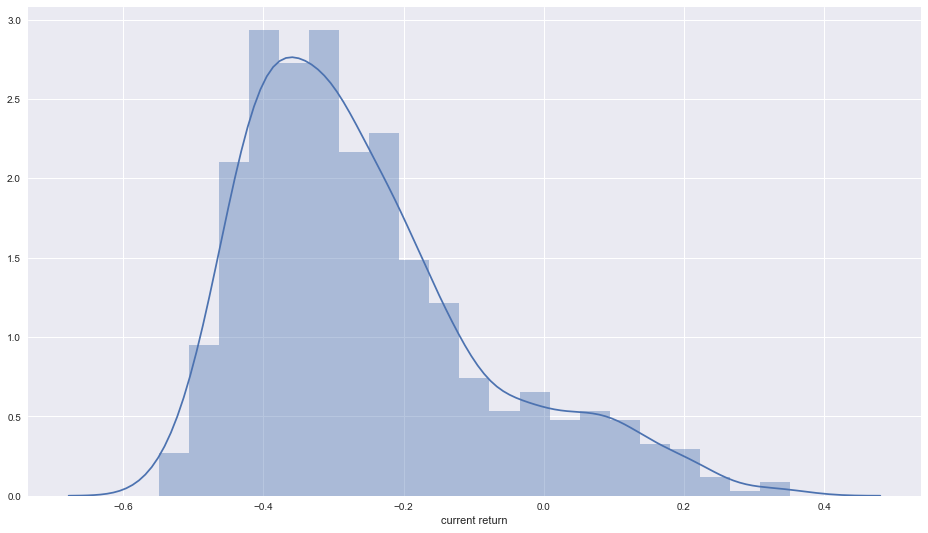

In [48]:
d = df["current return"].dropna()
plt.figure(figsize=(16, 9))
sns.distplot(d)

# 枚举所有日期，计算换手天数分布的变化

In [49]:
res = pd.DataFrame(index=pnl.major_axis)

In [50]:
res.loc[:, "kurtosis"] = np.nan
res.loc[:, "skewness"] = np.nan

In [51]:
for date in res.index:
    d = pnl.major_xs(date).ix["turnover days"].dropna()
#     d = pnl.major_axis(date).ix["current return"].dropna()
    if d.shape[0] >= 400:
        kurtosis = stats.kurtosis(d)
        skewness = stats.skew(d)
        res.ix[date] = {"kurtosis": kurtosis, "skewness": skewness}

In [134]:
start_date = "2016-03-01"

[[ 1.          0.71096719]
 [ 0.71096719  1.        ]]


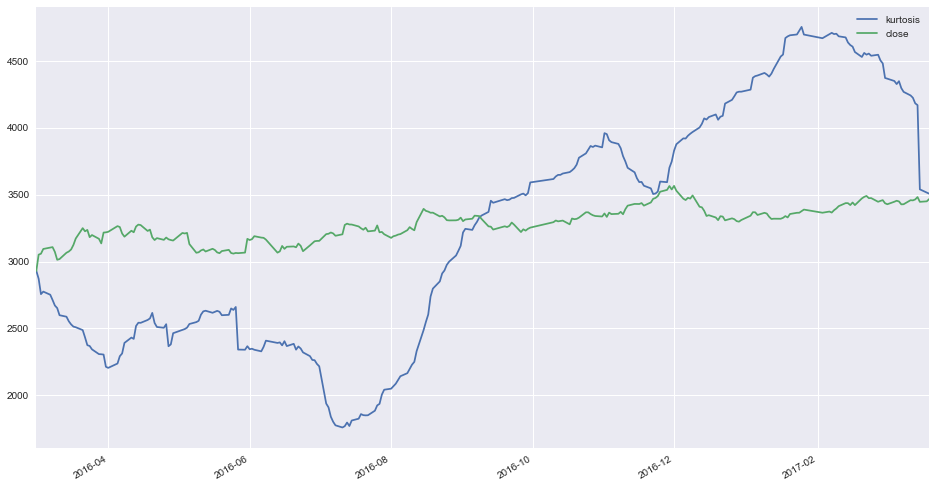

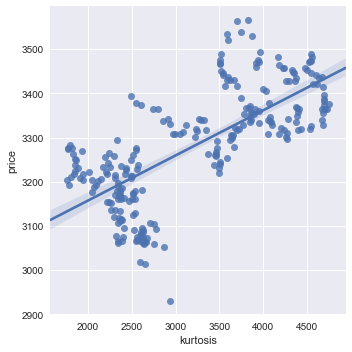

In [135]:
plt.figure(figsize=(16, 9))
a = (res[res.index >= start_date]["kurtosis"]*500)
a.plot(legend=True)
b = market_df[market_df.index >= start_date]["close"]
b.plot(legend=True)
print np.corrcoef(a, b)
df = pd.DataFrame({"kurtosis": a, "price": b})
sns.lmplot(x="kurtosis", y="price", data=df)

[[ 1.          0.62728707]
 [ 0.62728707  1.        ]]


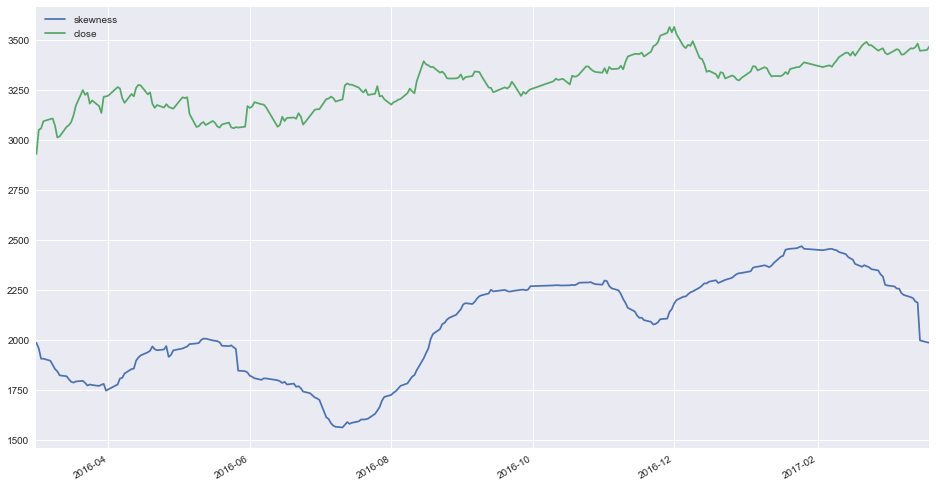

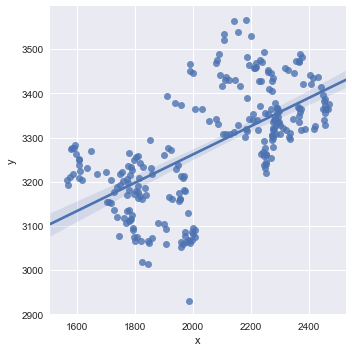

In [136]:
plt.figure(figsize=(16, 9))
a = (res[res.index >= start_date]["skewness"]*1000)
a.plot(legend=True)
b = market_df[market_df.index >= start_date]["close"]
b.plot(legend=True)
print np.corrcoef(a, b)
df = pd.DataFrame({"x": a, "y": b})
sns.lmplot(x="x", y="y", data=df)

In [137]:
dic = {"kurtosis": res["kurtosis"].values,
       "skewness": res["skewness"].values,
       "close": market_df["close"].values}

In [138]:
df = pd.DataFrame(dic, index=res.index)

In [139]:
k = 60
df["return"] = df["close"].pct_change(k)
df["y"] = df["return"].shift(-k)

In [140]:
df2016 = df[df.index >= start_date]

In [141]:
df2016["y"].corr(df["kurtosis"])

-0.27496778978707631

In [142]:
df2016["y"].corr(df["skewness"])

-0.15088242305412053

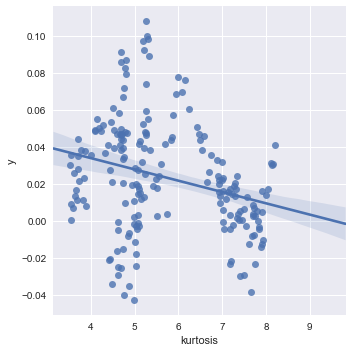

In [143]:
sns.lmplot(x='kurtosis', y='y', data=df2016)

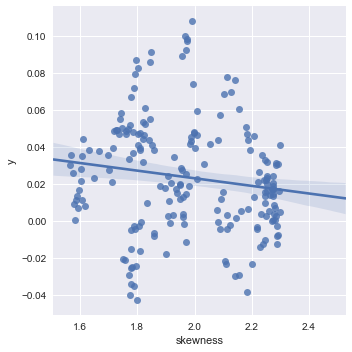

In [144]:
sns.lmplot(x='skewness', y='y', data=df2016)

In [145]:
ks = range(5, 123)
b_corrs = []
c_corrs = []
for k in ks:
    df["return"] = df["close"].pct_change(k)
    df["y"] = df["return"].shift(-k)
    df2016 = df[df.index >= start_date]
    b_corrs.append(df2016["y"].corr(df2016["kurtosis"]))
    c_corrs.append(df2016["y"].corr(df2016["skewness"]))

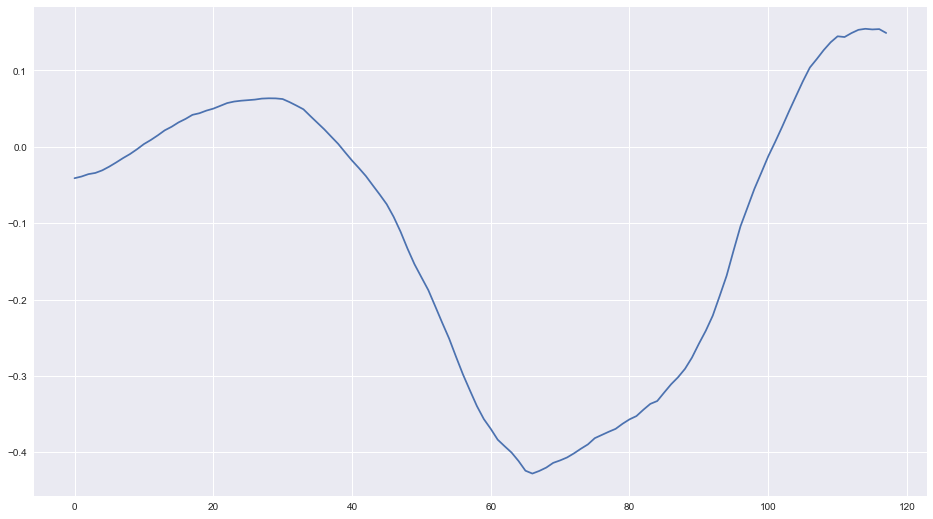

In [146]:
plt.figure(figsize=(16, 9))
plt.plot(b_corrs)

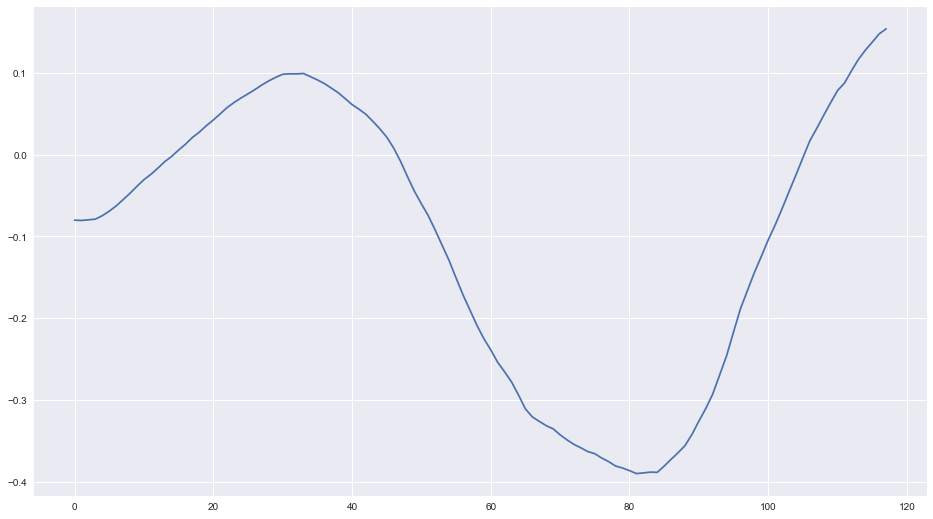

In [147]:
plt.figure(figsize=(16, 9))
plt.plot(c_corrs)

In [113]:
turnover_df = pnl.minor_xs("turnover days").mean(axis=1)

In [114]:
turnover_df = turnover_df[turnover_df.index >= start_date]

In [86]:
turnover_df.mean()

60.450753945539866

In [87]:
df2016

,close,kurtosis,skewness,return,y
2015-01-05 00:00:00.005,3641.5410,NaN,NaN,NaN,0.098034
2015-01-06 00:00:00.005,3641.0590,NaN,NaN,NaN,0.078808
2015-01-07 00:00:00.005,3643.7900,NaN,NaN,NaN,0.005282
2015-01-08 00:00:00.005,3559.2590,NaN,NaN,NaN,0.095067
2015-01-09 00:00:00.005,3546.7230,NaN,NaN,NaN,0.157845
2015-01-12 00:00:00.005,3513.5760,NaN,NaN,NaN,0.198725
2015-01-13 00:00:00.005,3514.0400,NaN,NaN,NaN,0.170205
2015-01-14 00:00:00.005,3502.4230,NaN,NaN,NaN,0.132576
2015-01-15 00:00:00.005,3604.1210,NaN,NaN,NaN,0.109107
2015-01-16 00:00:00.005,3635.1460,NaN,NaN,NaN,0.142044
